In [1]:
import sys
sys.path.append("../code/")
from common import APPLIANCES_ORDER
import tflearn
import tensorflow as tf



/Users/nipun/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tensor = np.load('../1H-input.npy')

In [4]:
def create_subset_dataset(tensor):
    t_subset = tensor[:, :, 180:194, :]
    all_indices = np.array(list(range(320)))
    for i in range(1, 7):
        valid_homes = pd.DataFrame(t_subset[:, i, :].reshape(320, 14*24)).dropna().index
        all_indices = np.intersect1d(all_indices, valid_homes)
    t_subset = t_subset[all_indices, :, :, :].reshape(52, 7, 14*24)
    
    # Create artificial aggregate
    t_subset[:, 0, :] = 0.0
    for i in range(1, 7):
        t_subset[:, 0, :] = t_subset[:, 0, :] + t_subset[:, i, :]
    # t_subset is of shape (#home, appliance, days*hours)
    return t_subset, all_indices

In [5]:
t_all, valid_homes = create_subset_dataset(tensor)
t_all.shape

(52, 7, 336)

In [6]:
t_all.shape

(52, 7, 336)

In [7]:
def my_objective(y_pred, y_true):
    with tf.name_scope(None):
        return tf.losses.absolute_difference(y_pred, y_true)

In [13]:
train_all = t_all[:20, :, :]
train_agg = train_all[:, 0, :]
train_agg_new = train_all[:, 0, :] - np.sum(train_all[:, 1:appliance_num, :])

In [14]:
train_all[0, [0, 1,2,3], 0]

array([ 701.56669402,  618.90002441,   70.05000305,    3.61666656])

In [15]:
ENERGY_MEAN = {APPLIANCES_ORDER[i]:np.mean(t_all[:, i, :]) for i in list(range(1, 7))}
ENERGY_MEAN = pd.Series(ENERGY_MEAN)
ENERGY_MEAN.sort_values(inplace=True, ascending=False)
ENERGY_MEAN

hvac      894.701044
fridge     89.265252
oven       16.646041
dw         13.984549
mw          6.417846
wm          5.083840
dtype: float64

In [1]:
train_

NameError: name 'train_agg_new' is not defined

In [15]:
i=1
appliance_name = "fridge"
appliance_num = APPLIANCES_ORDER.index(appliance_name)
tf.reset_default_graph()
print(appliance_num, appliance_name)
print("*"*80)
train_all = t_all[:20, :, :]
validation_all = t_all[20:30, :, :]
test_all = t_all[30:, :, :]
train_agg = train_all[:, 0, :]
if i>0:
    appliance_numbers_to_subtract = [APPLIANCES_ORDER.index(x)-1 for x in ENERGY_MEAN.index.values[:i]]
else:
    appliance_numbers_to_subtract = []
print(appliance_name)
print(appliance_numbers_to_subtract)
print(appliance_numbers_to_subtract, ENERGY_MEAN.index.values[appliance_numbers_to_subtract])
train_all[:, 0, :] - np.sum(train_all[:, [], :], axis=1)

2 fridge
********************************************************************************
fridge
[0]
[0] ['hvac']


array([[  701.56669402,   812.83332729,   508.74999142, ...,
         1889.1999979 ,  1681.71663618,  1951.79998064],
       [  946.95000434,   737.26666117,   719.23333418, ...,
         1667.43335   ,   941.41669184,  1080.08337259],
       [  144.75      ,   143.43333435,   142.43333435, ...,
         2611.46669984,  1065.61665154,  1021.58335686],
       ..., 
       [  283.30000305,   764.06666107,    54.41666794, ...,
          549.83333254,   116.66666412,   655.63334084],
       [   52.58333206,    51.68333435,    70.91666794, ...,
         2178.36660233,  1679.15004921,  1436.68327332],
       [ 2006.54999447,   441.39999235,  1150.21668315, ...,
         3080.83344746,  1330.51660967,  1900.3666234 ]])

In [325]:
np.random.seed(0)
pred = {}
pred_train = {}
aggs = {}

pred_validate = {}

mode = 1

# 0 - use GT gives UB
# 1 - use pred
# 2 - use GT for training, Pred for testing



# Predict HVAC using Aggregate data. No RNN for now.
for i, appliance_name in enumerate(ENERGY_MEAN.index[:]):
    appliance_num = APPLIANCES_ORDER.index(appliance_name)
    tf.reset_default_graph()
    print(appliance_num, appliance_name)
    print("*"*80)
    train_all = t_all[:20, :, :].copy()
    validation_all = t_all[20:30, :, :].copy()
    test_all = t_all[30:, :, :].copy()
    train_agg = train_all[:, 0, :].copy()
    if i>0:
        appliance_numbers_to_subtract = [APPLIANCES_ORDER.index(x) for x in ENERGY_MEAN.index.values[:i]]
    else:
        appliance_numbers_to_subtract = []
    print(appliance_name, appliance_numbers_to_subtract, [APPLIANCES_ORDER[x] for x in appliance_numbers_to_subtract])
    
    train_agg_new = train_all[:, 0, :].copy()
    validation_agg_new = validation_all[:, 0, :].copy()
    for appliance_subtract in [APPLIANCES_ORDER[x] for x in appliance_numbers_to_subtract]:
        print("Subtracting.. {}".format(appliance_subtract))
        
        if mode==0 or mode==2:
            train_agg_new-= train_all[:, APPLIANCES_ORDER.index(appliance_subtract), :]
            validation_agg_new-= validation_all[:, APPLIANCES_ORDER.index(appliance_subtract), :]
        else:
            train_agg_new-= pred_train[appliance_subtract]
            validation_agg_new-= pred_validate[appliance_subtract]
        train_agg_new[train_agg_new<0.] = 0.
        validation_agg_new[validation_agg_new<0.] = 0.
    train_appliance = train_all[:, appliance_num, :]
    validation_appliance = validation_all[:, appliance_num, :]
    
    net = tflearn.input_data(shape=[None, 336])
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    net = tflearn.fully_connected(net, 1000, activation='relu')
    net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 10000, activation='relu')
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    
    
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 1000, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    
    #net = tflearn.fully_connected(net, 336, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    #net = tflearn.fully_connected(net, 336, activation='relu')
    #net = tflearn.dropout(net, 0.8)
    
    net = tflearn.fully_connected(net, 336, activation='linear')
    net = tflearn.regression(net, loss=my_objective, learning_rate=1e-3, )
    #tflearn.lstm()
    model = tflearn.DNN(net, )
    # Start training (apply gradient descent algorithm)
    model.fit(train_agg_new ,train_appliance, n_epoch=30, batch_size=20, show_metric=True, 
          validation_set=(validation_agg_new, validation_appliance))
    test_agg_new = test_all[:, 0, :].copy()
    for appliance_subtract in [APPLIANCES_ORDER[x] for x in appliance_numbers_to_subtract]:
        print("Subtracting.. {}".format(appliance_subtract))
        if mode==0:
            test_agg_new-= test_all[:, APPLIANCES_ORDER.index(appliance_subtract),:]
        else:
            test_agg_new-= pred[appliance_subtract]
        
    test_agg_new[test_agg_new<0.] = 0.
    prediction = model.predict(test_agg_new, )
    aggs[appliance_name] = test_agg_new
    #prediction[prediction>test_agg_new] = test_agg_new[prediction>test_agg_new]
    prediction[prediction<0.] = 0.
    pred[appliance_name] = prediction
    pred_train[appliance_name] = model.predict(train_agg_new)
    pred_validate[appliance_name] = model.predict(validation_agg_new)
    #pred[appliance_name] = model.predict(test_all[:, 0, :]- np.sum(test_all[:, appliance_numbers_to_subtract, :], axis=1))

1 hvac
********************************************************************************
hvac [] []
---------------------------------
Run id: ZHKG5A
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 20
Validation samples: 10
--
Training Step: 1  | time: 1.150s
| Adam | epoch: 001 | loss: 0.00000 - acc: 0.0000 | val_loss: 752.90997 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 2  | total loss: 803.40131 | time: 1.040s
| Adam | epoch: 002 | loss: 803.40131 - acc: 0.0000 | val_loss: 545.53003 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 3  | total loss: 811.15216 | time: 1.026s
| Adam | epoch: 003 | loss: 811.15216 - acc: 0.0000 | val_loss: 922.97083 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 4  | total loss: 659.17145 | time: 1.028s
| Adam | epoch: 004 | loss: 659.17145 - acc: 0.0375 | val_loss: 955.93134 - val_acc: 0.1000 -- iter: 20/20
--
Trainin

Training Step: 13  | total loss: 42.93262 | time: 1.029s
| Adam | epoch: 013 | loss: 42.93262 - acc: 0.0011 | val_loss: 49.23911 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 14  | total loss: 40.35055 | time: 1.025s
| Adam | epoch: 014 | loss: 40.35055 - acc: 0.0006 | val_loss: 48.12181 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 15  | total loss: 40.28378 | time: 1.061s
| Adam | epoch: 015 | loss: 40.28378 - acc: 0.0004 | val_loss: 40.86690 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 16  | total loss: 39.62875 | time: 1.031s
| Adam | epoch: 016 | loss: 39.62875 - acc: 0.0002 | val_loss: 34.26380 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 17  | total loss: 36.83265 | time: 1.033s
| Adam | epoch: 017 | loss: 36.83265 - acc: 0.0002 | val_loss: 35.34230 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 18  | total loss: 34.42269 | time: 1.027s
| Adam | epoch: 018 | loss: 34.42269 - acc: 0.0174 | val_loss: 35.40853 - val_acc: 0.0000 -- iter: 20/20
--
Training S

Training Step: 26  | total loss: 11.56185 | time: 1.023s
| Adam | epoch: 026 | loss: 11.56185 - acc: 0.0261 | val_loss: 13.08927 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 27  | total loss: 11.51548 | time: 1.026s
| Adam | epoch: 027 | loss: 11.51548 - acc: 0.0194 | val_loss: 13.09656 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 28  | total loss: 11.45953 | time: 1.023s
| Adam | epoch: 028 | loss: 11.45953 - acc: 0.0145 | val_loss: 13.07884 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 29  | total loss: 11.41270 | time: 1.032s
| Adam | epoch: 029 | loss: 11.41270 - acc: 0.0110 | val_loss: 13.13635 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 30  | total loss: 11.38786 | time: 1.028s
| Adam | epoch: 030 | loss: 11.38786 - acc: 0.0084 | val_loss: 13.15008 - val_acc: 0.0000 -- iter: 20/20
--
Subtracting.. hvac
Subtracting.. fridge
4 dw
********************************************************************************
dw [1, 2, 6] ['hvac', 'fridge', 'oven']
Subtracti

Training Step: 7  | total loss: 6.03662 | time: 1.028s
| Adam | epoch: 007 | loss: 6.03662 - acc: 0.0000 | val_loss: 5.25969 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 8  | total loss: 5.74462 | time: 1.029s
| Adam | epoch: 008 | loss: 5.74462 - acc: 0.0000 | val_loss: 5.40789 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 9  | total loss: 5.90795 | time: 1.039s
| Adam | epoch: 009 | loss: 5.90795 - acc: 0.0000 | val_loss: 5.52605 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 10  | total loss: 6.11316 | time: 1.025s
| Adam | epoch: 010 | loss: 6.11316 - acc: 0.0000 | val_loss: 5.41920 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 11  | total loss: 5.78746 | time: 1.032s
| Adam | epoch: 011 | loss: 5.78746 - acc: 0.0000 | val_loss: 5.39791 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 12  | total loss: 6.01226 | time: 1.039s
| Adam | epoch: 012 | loss: 6.01226 - acc: 0.0000 | val_loss: 5.27499 - val_acc: 0.0000 -- iter: 20/20
--
Training Step: 13  | total loss

Training Step: 20  | total loss: 4.68104 | time: 1.023s
| Adam | epoch: 020 | loss: 4.68104 - acc: 0.0409 | val_loss: 4.72721 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 21  | total loss: 4.67973 | time: 1.025s
| Adam | epoch: 021 | loss: 4.67973 - acc: 0.0437 | val_loss: 4.72717 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 22  | total loss: 4.67862 | time: 1.029s
| Adam | epoch: 022 | loss: 4.67862 - acc: 0.0456 | val_loss: 4.72713 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 23  | total loss: 4.67917 | time: 1.023s
| Adam | epoch: 023 | loss: 4.67917 - acc: 0.0469 | val_loss: 4.72708 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 24  | total loss: 4.67827 | time: 1.026s
| Adam | epoch: 024 | loss: 4.67827 - acc: 0.0477 | val_loss: 4.72705 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 25  | total loss: 4.67769 | time: 1.026s
| Adam | epoch: 025 | loss: 4.67769 - acc: 0.0484 | val_loss: 4.72703 - val_acc: 0.1000 -- iter: 20/20
--
Training Step: 26  | total l

In [326]:
pd.DataFrame(test_all[:, APPLIANCES_ORDER.index(appliance_subtract),:]).head()

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,4.0,4.00,4.0,4.0,3.933333,3.850000,4.000000,27.150000,3.933333,4.0,...,3.883333,4.000000,3.666667,101.599998,3.833333,4.0,3.916667,4.0,4.00,4.0
1,0.0,0.00,0.0,0.0,0.000000,0.000000,24.750000,0.000000,8.100000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.00,0.0
2,0.1,1.75,0.7,0.0,1.550000,1.133333,3.716667,32.083332,1.700000,1.3,...,2.316667,2.116667,1.650000,0.150000,22.583334,0.4,0.250000,0.0,0.50,0.0
3,0.0,0.00,0.0,0.0,0.000000,0.000000,2.283333,46.166668,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,2.300000,0.0,0.000000,1.0,0.15,0.0
4,0.0,0.00,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,1.800000,0.000000,0.0,0.000000,0.0,0.00,0.0


In [327]:
pd.DataFrame(test_all[:, 0,:]).head()

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,352.516682,340.699990,359.050010,338.966678,426.450006,1547.466684,102.233334,535.716655,522.716683,676.616676,...,931.316675,1229.500018,1206.849958,1928.150035,1542.616708,935.650029,1111.533361,681.733311,754.899971,354.250007
1,380.583328,342.583328,192.433327,174.483335,276.333330,178.266670,242.283333,556.400009,1455.733286,1196.299956,...,1854.683304,1824.800049,1742.383343,1689.666649,1645.349953,1580.816658,1810.166658,1576.366652,1468.016716,1283.483356
2,937.649986,795.550011,821.733350,428.583339,359.533322,681.249988,689.433314,787.616667,611.616664,765.916641,...,2300.866575,2836.833214,2760.449886,2844.449936,2949.966561,2704.633313,1864.099959,1597.566682,1613.116652,1008.916670
3,873.183301,701.866665,587.850003,647.716647,651.699980,860.949975,707.966669,825.249979,841.166664,1162.783314,...,2707.649948,3373.999954,3451.800018,3287.000015,3179.549953,3060.966670,226.483326,854.133358,1480.983377,1115.699952
4,791.016682,633.650019,596.416674,663.816649,797.016674,640.049991,453.999993,268.650004,345.466671,225.900010,...,1140.149987,1132.049964,1328.500014,1283.283280,1232.333360,1095.850016,1003.233340,678.699989,1324.666630,1002.100020


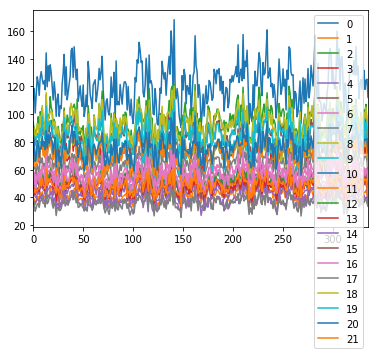

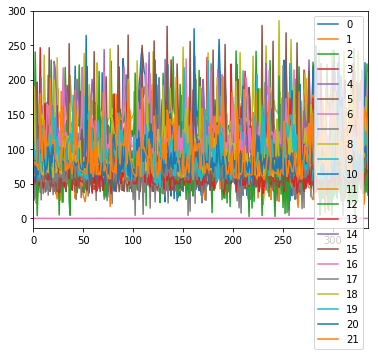

In [328]:
pd.DataFrame(pred['fridge']).T.plot()

pd.DataFrame(test_all[:,APPLIANCES_ORDER.index('fridge'),:]).T.plot()

In [329]:
test_agg_new.mean()

290.84109336054553

In [330]:
pred['hvac'].mean()

851.84821

In [331]:
test_all[:, 0, :].mean()

1072.7840002015712

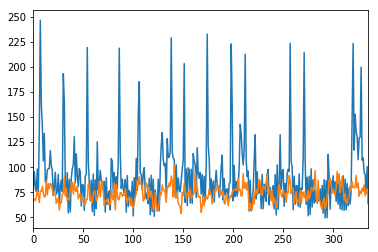

In [332]:
#pd.Series(test_all[21, 0, :]).plot()
appliance="fridge"
appliance_num = APPLIANCES_ORDER.index(appliance)
home = 3
pd.Series(test_all[home, appliance_num, :]).plot()


pd.Series(pred[appliance][home, :]).plot()

In [333]:
pd.DataFrame(aggs['fridge'])

,0,1,2,3,4,5,6,7,8,9,...,326,327,328,329,330,331,332,333,334,335
0,19.970173,49.997017,0.000000,104.536472,255.967202,1200.945749,0.000000,181.941478,121.885201,175.738044,...,0.000000,12.042133,28.878889,605.468760,178.757211,0.000000,221.862951,0.000000,220.467659,0.000000
1,23.100143,42.309616,0.000000,0.000000,93.567415,0.000000,78.052086,187.134750,1043.899149,681.875945,...,686.485306,565.177612,513.949627,306.567528,213.272438,304.440681,875.711519,627.920241,901.961601,751.915180
2,437.555626,388.399285,189.453686,119.263118,119.127041,219.006213,476.552455,293.924468,85.291224,88.961746,...,755.622679,1160.248986,1118.439876,977.109116,1038.052498,988.833142,608.644759,322.512239,844.666151,283.869246
3,230.154737,142.683071,0.000000,197.952182,315.400481,192.459130,399.685602,140.259378,52.213661,187.518788,...,519.697800,1015.959427,1166.571503,732.483170,533.221584,709.411006,0.000000,0.000000,442.187845,160.826172
4,417.784687,347.265497,144.930285,455.330947,625.411938,309.356936,310.321527,0.000000,0.000000,0.000000,...,66.828210,0.000000,173.510512,0.000000,0.000000,0.000000,109.187198,0.000000,773.446354,474.299178
5,411.667461,144.953090,0.000000,301.207514,420.119467,120.632916,0.000000,189.884678,135.808947,0.000000,...,681.495093,1006.108105,285.418896,1319.090398,528.162305,232.193684,0.000000,828.094994,655.662453,58.434970
6,552.727173,220.753546,25.518490,288.355271,0.000000,163.053312,0.000000,0.000000,0.000000,0.000000,...,0.000000,1629.271671,1795.696777,1248.674992,1130.116056,1211.576538,1574.697697,0.000000,430.122323,815.812325
7,0.000000,0.000000,0.000000,0.000000,57.981608,0.000000,32.779325,0.000000,0.000000,0.000000,...,204.401126,479.739616,705.733331,0.000000,119.872222,0.000000,157.730514,100.514094,302.278312,233.956753
8,494.664212,419.748597,0.000000,230.792984,0.000000,0.000000,942.155692,0.000000,343.494949,0.000000,...,69.478862,446.485157,1093.174979,572.312678,533.246650,0.000000,0.000000,0.000000,0.000000,1518.048408
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,303.303756,705.270834,527.821615,...,0.000000,0.000000,0.000000,23.409931,1504.585275,1478.104541,702.550384,0.000000,1074.577078,128.061711


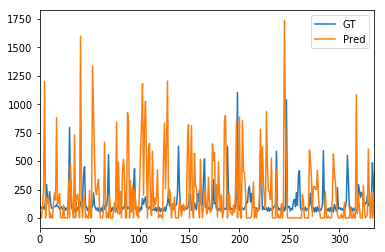

In [334]:
pd.Series(test_all[home, 0, :]-test_all[home, 1, :]).plot(label='GT')
pd.DataFrame(aggs['fridge']).loc[0].plot(label='Pred')
plt.legend()

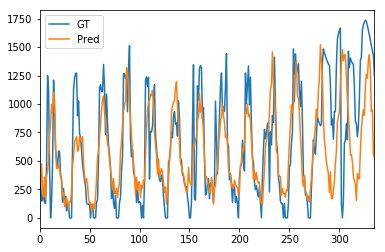

In [335]:
#pd.DataFrame(aggs['fridge']).loc[0].plot()
#pd.DataFrame(aggs['hvac']-test_all[0, 1, :]).loc[0].plot()
home = 1
pd.Series(test_all[home, 1, :]).plot(label='GT')


pd.DataFrame(pred['hvac']).loc[home].plot(label='Pred')
plt.legend()


In [336]:
pd.DataFrame(test_all[0, 0, :])

,0
0,352.516682
1,340.699990
2,359.050010
3,338.966678
4,426.450006
5,1547.466684
6,102.233334
7,535.716655
8,522.716683
9,676.616676


In [337]:
gt = tensor[valid_homes, :, 180:194, :][30:, :, :, :].reshape(22, 7, 336)

In [338]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 14.49934903123088,
 'fridge': 38.578239118417287,
 'hvac': 401.80151754070539,
 'mw': 6.204401698959936,
 'oven': 18.528210689369651,
 'wm': 5.6177957878908371}

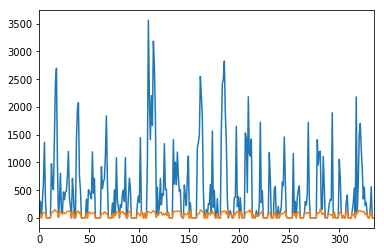

In [274]:
#pd.Series(test_all[0, 0, :]).plot()
home = 10
appliance=2
pd.Series(test_agg_new[home,:]).plot()


#pd.Series(test_all[home, appliance, :]).plot()
pd.Series(pred['fridge'][home, :]).plot()

In [275]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

KeyError: 'mw'

<tf.Tensor 'read:0' shape=(336, 336) dtype=float32>

In [66]:
pd.Series(err)

dw         24.501916
fridge     40.642623
hvac      407.645032
mw          9.477331
oven       24.559614
wm          9.269064
dtype: float64

In [44]:
err = {}
for appliance in APPLIANCES_ORDER[1:]:
    appliance_num = APPLIANCES_ORDER.index(appliance)
    x = pred[appliance]
    x[x<0.] = 0.
    err[appliance] = np.abs(x-gt[:,appliance_num,:]).mean()
err

{'dw': 24.870927145657255,
 'fridge': 40.642622669315109,
 'hvac': 407.64503194612212,
 'mw': 9.5177636509070478,
 'oven': 24.630917072655215,
 'wm': 9.4858786798710284}

In [46]:
pd.Series(err).mean()

86.13219019408797

In [50]:
(pd.DataFrame(pred['hvac'])-pd.DataFrame(gt[:,1,:])).abs().sum(axis=1)

0      76795.709343
1      90376.204248
2     107125.516512
3     154093.437996
4      75034.047701
5     112149.631845
6     161112.576504
7     126881.272907
8     125538.213085
9     189063.335770
10    215992.330513
11    205689.315586
12    214037.400083
13     88024.450001
14     88011.922891
15    162560.397587
16    102536.124285
17     76096.244452
18    194650.624890
19    126364.546612
20    210910.802409
21    110267.970926
dtype: float64

In [495]:
pd.DataFrame(err_sc).min(axis=1)

dw        98.465801
fridge    65.367590
hvac      76.061186
mw        69.195618
oven      59.718504
wm        50.857821
dtype: float64

In [51]:
def accuracy_pie_chart(ground_truth_appliance, prediction_appliance, gt_aggregate):
    out = 0.
    for i in range(6):
        out = out + min(np.sum(ground_truth_appliance[:, i, :]), np.sum(prediction_appliance[:, i, :]))
    return out/np.sum(gt_aggregate)    

In [55]:
approach_pred = {'Neural':pred}

pie_accuracies = {}
for approach_name, approach_prediction in approach_pred.items():
    pie_accuracies[approach_name] = accuracy_pie_chart(gt, approach_prediction, test_all[:, 0, :])

TypeError: unhashable type: 'slice'

Text(0,0.5,'Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)')

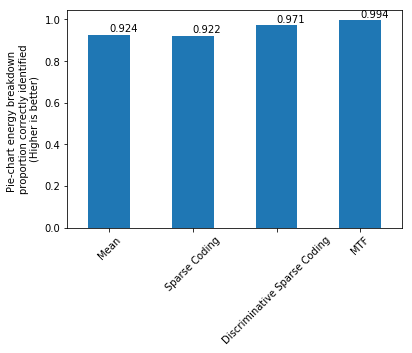

In [526]:
pie_accuracies = pd.Series(pie_accuracies).loc[['Mean','Sparse Coding','Discriminative Sparse Coding','MTF']]
ax = pie_accuracies.plot(kind='bar',rot=45)
for i, v in enumerate(pie_accuracies):
    ax.text( i,v+0.03, str(v.round(3)), va='center')
plt.ylabel("Pie-chart energy breakdown \nproportion correctly identified\n(Higher is better)")

In [522]:
pd.Series(pie_accuracies).

Discriminative Sparse Coding    0.971380
MTF                             0.994402
Mean                            0.923875
Sparse Coding                   0.921797
dtype: float64

In [487]:
mean_pred = np.zeros_like(pred_mtf)
mean_pred[:, :, :] = train_data.mean(axis=2)

In [488]:
mean_pred.shape

(22, 6, 336)

In [490]:
err_mean

{'dw': 101.42720929364509,
 'fridge': 76.717538971029512,
 'hvac': 78.719166409204803,
 'mw': 72.453527550654172,
 'oven': 65.686567624501521,
 'wm': 73.401499222720375}